In [1]:
import numpy as np
import pandas as pd
import tqdm
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
import time
from gensim import corpora,models
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.parsing.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import sklearn
import gensim

In [2]:
data = pd.read_csv("data/abcnews-date-text.csv")

In [3]:
data.shape

(1186018, 2)

In [4]:
data.head()

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


In [5]:
data['date'] = data.publish_date.apply(lambda x:pd.to_datetime(str(x)))

In [6]:
data.date.head()

0   2003-02-19
1   2003-02-19
2   2003-02-19
3   2003-02-19
4   2003-02-19
Name: date, dtype: datetime64[ns]

In [7]:
data.date.head()

0   2003-02-19
1   2003-02-19
2   2003-02-19
3   2003-02-19
4   2003-02-19
Name: date, dtype: datetime64[ns]

In [9]:
year_freq = data['date'].apply(lambda x : x.year)
year_freq = year_freq.value_counts()

In [10]:
year_freq

2013    91928
2012    89008
2014    81531
2008    79991
2011    77778
2015    77290
2007    77174
2009    76444
2010    74931
2005    73124
2004    72674
2006    66901
2003    63997
2016    61574
2017    47511
2018    40102
2019    34060
Name: date, dtype: int64

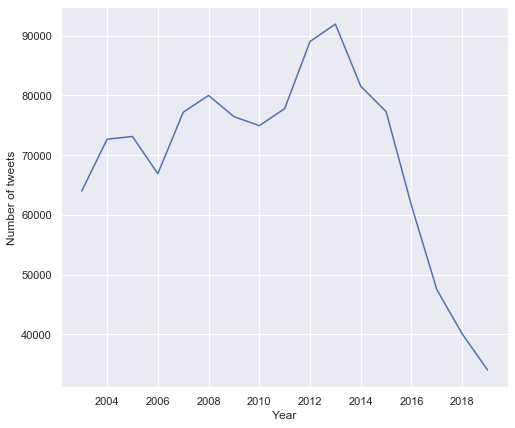

In [12]:
sns.set()
plt.figure(figsize=(8,7))
plt.xlabel("Year")
plt.ylabel("Number of tweets")
sns.set()
sns.lineplot(x = year_freq.index,y = year_freq.values)
plt.show()

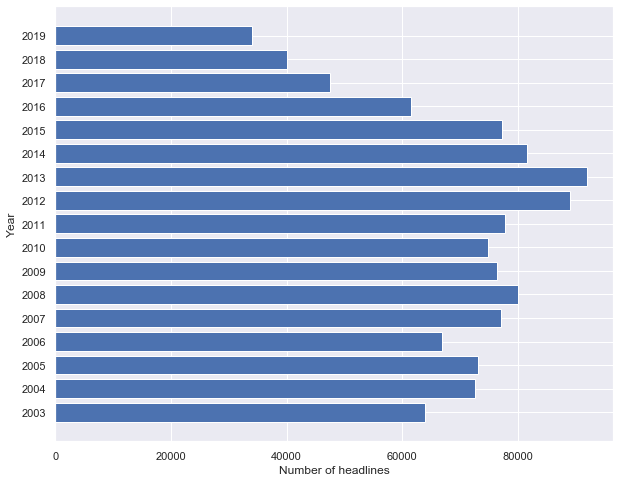

In [13]:
sns.set()
fig,ax = plt.subplots()
d = pd.DataFrame(data={"year":year_freq.index,"frequency":year_freq.values})
ax.barh(width = 'frequency', y= 'year',data = d)
ax.set_yticks(d['year'])
fig.set_figheight(8)
fig.set_figwidth(10)
ax.set_xlabel("Number of headlines")
ax.set_ylabel("Year")
plt.show()

### Text Preprocessing using NLTK and GENSIM

In [15]:
data.head()

,publish_date,headline_text,date
0,20030219,aba decides against community broadcasting lic...,2003-02-19
1,20030219,act fire witnesses must be aware of defamation,2003-02-19
2,20030219,a g calls for infrastructure protection summit,2003-02-19
3,20030219,air nz staff in aust strike for pay rise,2003-02-19
4,20030219,air nz strike to affect australian travellers,2003-02-19


In [16]:
data.drop(columns=['publish_date'],inplace=True)

In [17]:
data.headline_text.head()

0    aba decides against community broadcasting lic...
1       act fire witnesses must be aware of defamation
2       a g calls for infrastructure protection summit
3             air nz staff in aust strike for pay rise
4        air nz strike to affect australian travellers
Name: headline_text, dtype: object

In [18]:
data.headline_text.apply(lambda x:x.lower()).head()

0    aba decides against community broadcasting lic...
1       act fire witnesses must be aware of defamation
2       a g calls for infrastructure protection summit
3             air nz staff in aust strike for pay rise
4        air nz strike to affect australian travellers
Name: headline_text, dtype: object

In [19]:
def text_preprocess(x,stemmer,word2cnt={}):
        
    x = simple_preprocess(x)
    
    x = [word for word in x if word not in STOPWORDS]
    
    x = [word for word in x if len(word)>3]

    x = [stemmer.stem(WordNetLemmatizer().lemmatize(word,pos='v')) for word in x]
    
    for word in x:
        word2cnt[word] = word2cnt.get(word,0) + 1
    return x

In [20]:

stemmer = PorterStemmer()

In [21]:
sample = data.iloc[0,0]
print("before preprocessing\n",sample)
print("after preprocessing\n",text_preprocess(sample,stemmer))

before preprocessing
 aba decides against community broadcasting licence
after preprocessing
 ['decid', 'commun', 'broadcast', 'licenc']


In [22]:
word2cnt = {}

In [23]:
data['token'] = data.headline_text.apply(lambda x: text_preprocess(x,stemmer,word2cnt))

In [24]:
data.token.head()

0        [decid, commun, broadcast, licenc]
1                        [wit, awar, defam]
2    [call, infrastructur, protect, summit]
3               [staff, aust, strike, rise]
4      [strike, affect, australian, travel]
Name: token, dtype: object

### Create Dictionary for corpus

In [25]:
dictionary = corpora.Dictionary(data.token)

In [26]:
for word,index in list(dictionary.iteritems())[:10]:
    print(word,index)

0 broadcast
1 commun
2 decid
3 licenc
4 awar
5 defam
6 wit
7 call
8 infrastructur
9 protect


In [27]:
w2c = list(word2cnt.items())

In [28]:
len(w2c)

67259

In [29]:
w2c.sort(key=lambda x:x[1],reverse=True)

In [30]:
words = [word for word,_ in w2c[:15]]
counts = [count for _,count in w2c[:15]]

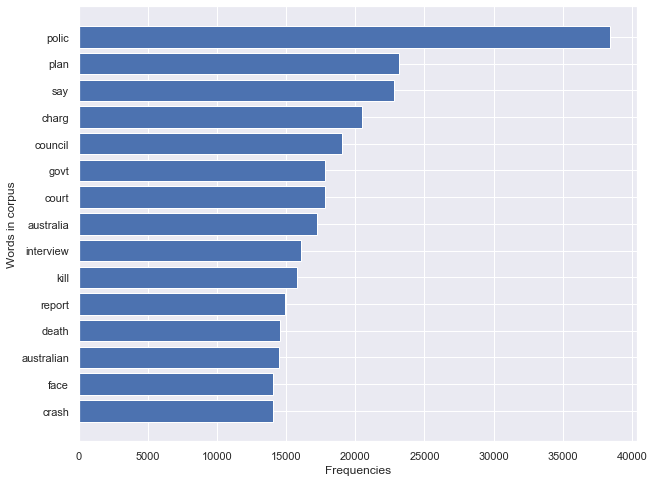

In [31]:
sns.set()
fig,ax = plt.subplots()
d = pd.DataFrame(data={"words":words[::-1],"counts":counts[::-1]})
ax.barh(width = 'counts', y= 'words',data = d)
ax.set_yticks(d['words'])
fig.set_figheight(8)
fig.set_figwidth(10)
ax.set_ylabel("Words in corpus")
ax.set_xlabel("Frequencies")
plt.show()

## NMF Modelling 